## Synthesizing simple complex hologram

In [1]:
# import modules
import torch
import torchOptics.optics as tt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import warnings
warnings.filterwarnings('ignore')

folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/' # define dataset folder
device = 'cuda' # define device
z = 2e-3 # propagation distance
meta = {'dx':[6.3e-6, 6.3e-6], 'wl':[515e-9]} # pixel pitch

net = tt.Net(in_channels=[1]+[32 for _ in range(20)]+[2], activations='LeakyReLU').to(device)
dataset = tt.MultiImageDatasetImageio(folder, transform=transforms.Compose([transforms.ToTensor(), 
                                                                            transforms.Grayscale(), 
                                                                            transforms.RandomCrop((1024,1024), pad_if_needed=True)]))
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

loss_history = []
net.train()
for epoch in range(5):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output[:,[0]] + output[:,[1]]*1j # convert output to complex field, note that the channel of the network output is 2.
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

    if epoch==0:
        net.eval()
        net._clear_train()
        net.train()

/usr/local/lib/python3.8/dist-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
0.0004: 100%|██████████| 800/800 [02:18<00:00,  5.77it/s]


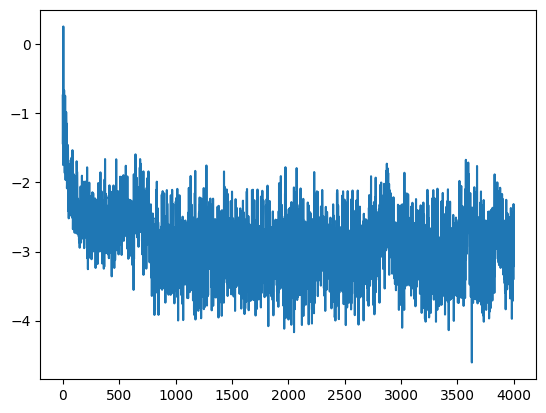

In [3]:
plt.plot(np.log10(loss_history))
plt.show()

=> mse is lower than 0.001 => PSNR > 30 dB

## Direct amplitude-only hologram

In [4]:
net = tt.Net(in_channels=[1]+[32 for _ in range(20)]+[1], activations='LeakyReLU').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

loss_history = []
net.train()
for epoch in range(5):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output # output is amplitude-only field, note that the channel of the network output is 1.
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

    if epoch==0:
        net.eval()
        net._clear_train()
        net.train()

0.0024: 100%|██████████| 800/800 [02:15<00:00,  5.92it/s]


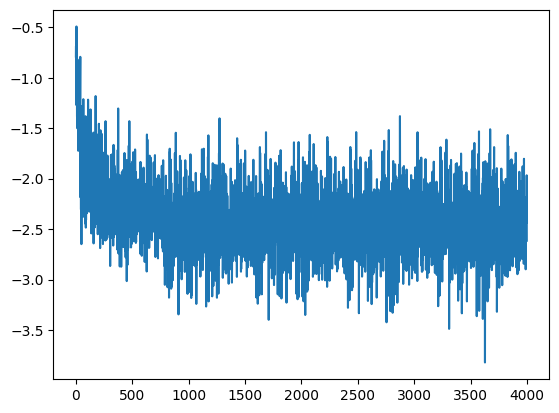

In [5]:
plt.plot(np.log10(loss_history))
plt.show()


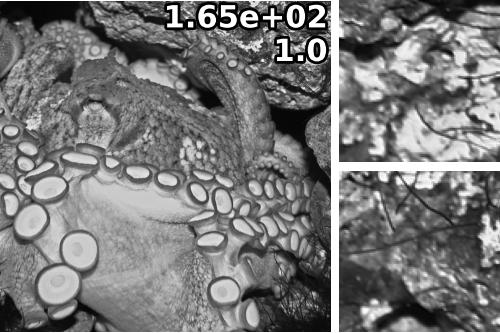
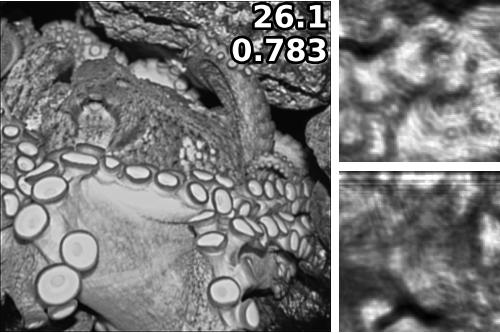

In [6]:
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

In [7]:
# approximate PSNR over history
np.mean(10*np.log10(loss_history[-800:]))

-24.446553255072487

## better network?

In [ ]:
import torchOptics.models as tm

# NetPropNetSame: Net + propagation + Net
# To define Net, search model_name from model_module and use it as a base class
# Since complex propagation applied in the middle, channels should be half of the 'wl' in the meta.
kwargs = {"model_kwargs1":{"in_channels":[1] + [32 for _ in range(10)] + [24],"biases":True,"last_layer_type":"Hardtanh","last_layer_args":[0,1],"pixel_shuffle":1,"activations":"LeakyReLU"}, "model_kwargs2":{"in_channels":[24] + [32 for _ in range(10)] + [1], "biases":True,"last_layer_type":"Hardtanh","last_layer_args":[0,1],"pixel_shuffle":1,"activations":"LeakyReLU"}}
net = tm.NetPropNetSame(meta = {'dx':[6.3e-6, 6.3e-6], 'wl':[515e-9 for _ in range(12)], "z": -z}, 
                        model_module='',
                        model_name='ShuffleResnet',
                        **kwargs).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

loss_history = []
net.train()
for epoch in range(5):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output # output is amplitude-only field, note that the channel of the network output is 1.
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

    if epoch==0:
        net.eval()
        net._clear_train()
        net.train()

0.0010:  93%|█████████▎| 747/800 [02:23<00:10,  5.24it/s]

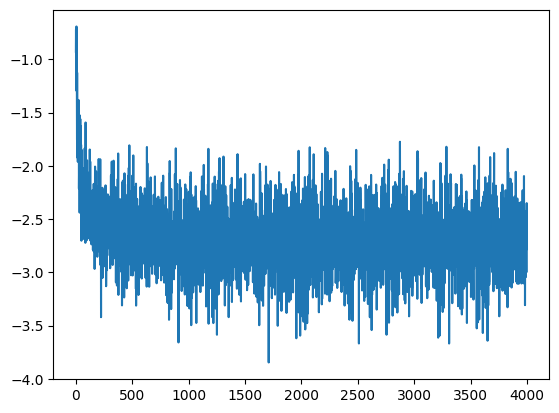

In [14]:
plt.plot(np.log10(loss_history))
plt.show()


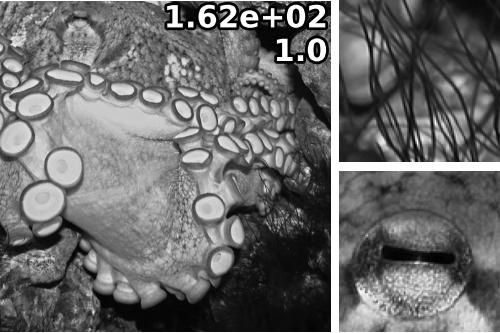
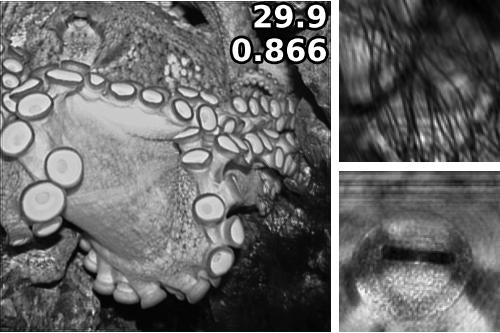

In [15]:
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

In [16]:
# approximate PSNR over history
np.mean(10*np.log10(loss_history[-800:]))

-26.977769807291917

## More epochs

In [2]:
import torchOptics.models as tm

# NetPropNetSame: Net + propagation + Net
# To define Net, search model_name from model_module and use it as a base class
# Since complex propagation applied in the middle, channels should be half of the 'wl' in the meta.
kwargs = {"model_kwargs1":{"in_channels":[1] + [32 for _ in range(10)] + [24],"biases":True,"last_layer_type":"Hardtanh","last_layer_args":[0,1],"pixel_shuffle":1,"activations":"LeakyReLU"}, "model_kwargs2":{"in_channels":[24] + [32 for _ in range(10)] + [1], "biases":True,"last_layer_type":"Hardtanh","last_layer_args":[0,1],"pixel_shuffle":1,"activations":"LeakyReLU"}}
net = tm.NetPropNetSame(meta = {'dx':[6.3e-6, 6.3e-6], 'wl':[515e-9 for _ in range(12)], "z": -z}, 
                        model_module='',
                        model_name='ShuffleResnet',
                        **kwargs).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

loss_history = []
net.train()
for epoch in range(50):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output # output is amplitude-only field, note that the channel of the network output is 1.
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

    if epoch==0:
        net.eval()
        net._clear_train()
        net.train()

0.0015:  19%|█▉        | 154/800 [00:29<02:01,  5.34it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

0.0010: 100%|██████████| 800/800 [02:30<00:00,  5.30it/s]


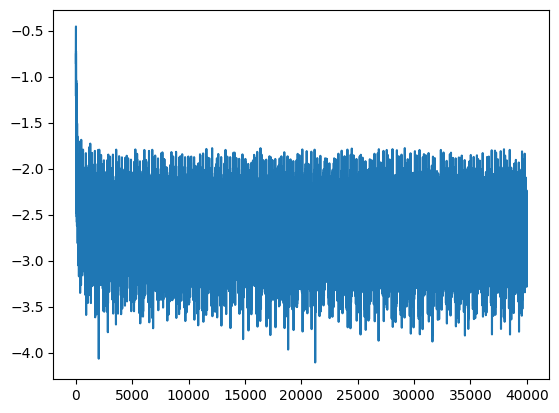

In [13]:
plt.plot(np.log10(loss_history))
plt.show()


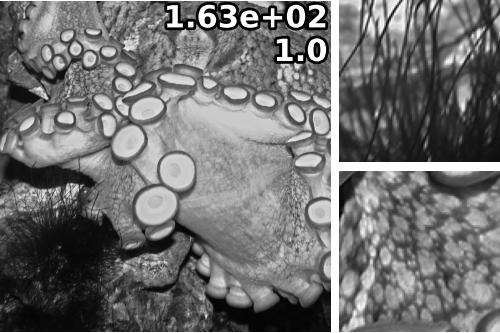
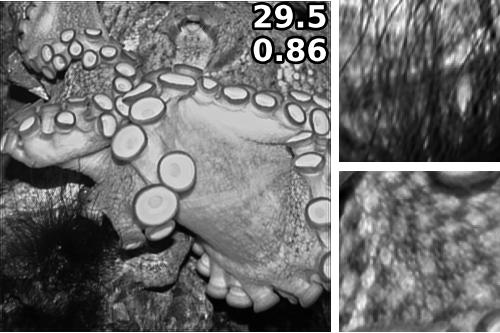

In [14]:
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

In [15]:
# approximate PSNR over history
np.mean(10*np.log10(loss_history[-800:]))

-27.174171809113005

In [ ]:
# 필요한 모듈 임포트
import torch
import torchOptics.optics as tt  # torchOptics의 optics 모듈 사용
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import warnings

# 경고 메시지를 무시하도록 설정
warnings.filterwarnings('ignore')

# 데이터셋 폴더 경로 설정
folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/'
device = 'cuda'  # 학습을 GPU에서 실행하도록 설정
z = 2e-3  # 전파 거리 (2mm)
meta = {'dx': [6.3e-6, 6.3e-6], 'wl': [515e-9]}  # 픽셀 피치와 파장 설정

# 네트워크 정의: 입력 채널 1개, 출력 채널 2개, 총 20개의 히든 레이어를 LeakyReLU 활성화 함수로 구성
net = tt.Net(in_channels=[1] + [32 for _ in range(20)] + [2], activations='LeakyReLU').to(device)

# 데이터셋 생성: 이미지 읽기, 그레이스케일 변환 및 1024x1024 무작위 자르기 적용
dataset = tt.MultiImageDatasetImageio(folder, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.RandomCrop((1024, 1024), pad_if_needed=True)
]))

# 옵티마이저 정의: 학습 속도 0.001로 설정
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 데이터 로더 생성: 배치 크기 1, 데이터 병렬 처리를 위해 6개의 워커 사용
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

# 학습 루프: 5 에포크 동안 학습 수행
loss_history = []  # 손실 기록
net.train()  # 네트워크를 학습 모드로 설정
for epoch in range(5):
    pbar = tqdm.tqdm(dataloader)  # 진행 상태 표시줄
    for data in pbar:
        optimizer.zero_grad()  # 옵티마이저 기울기 초기화
        x = data[0].to(device)  # 입력 데이터 GPU로 이동
        output = tt.Tensor(net(x), meta=meta)  # 네트워크 출력 생성
        # 네트워크의 출력은 복소수 필드로 변환
        field = output[:, [0]] + output[:, [1]] * 1j
        # 전파 시뮬레이션 수행
        sim = tt.simulate(field, -z).abs()**2
        # 손실 계산: 입력과 시뮬레이션 출력의 MSE 손실
        loss = F.mse_loss(sim, x)
        loss.backward()  # 역전파로 기울기 계산
        optimizer.step()  # 매개변수 업데이트
        pbar.set_description('{:.4f}'.format(loss.item()))  # 진행 상태 표시
        loss_history.append(loss.item())  # 손실 기록

    # 첫 에포크 후 네트워크를 평가 모드로 전환 후 재설정
    if epoch == 0:
        net.eval()
        net._clear_train()
        net.train()

# 손실 기록 시각화
plt.plot(np.log10(loss_history))  # 로그 스케일로 손실 시각화
plt.show()

# 새로운 네트워크 구성: 입력 채널 1, 출력 채널 1로 설정
net = tt.Net(in_channels=[1] + [32 for _ in range(20)] + [1], activations='LeakyReLU').to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)  # 학습 속도 변경

# 학습 루프: 위와 동일한 절차 수행
loss_history = []
net.train()
for epoch in range(5):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        # 출력은 진폭만 포함하는 필드로 간주
        field = output
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

    if epoch == 0:
        net.eval()
        net._clear_train()
        net.train()

# 손실 기록 시각화
plt.plot(np.log10(loss_history))
plt.show()

# 입력 이미지와 시뮬레이션 출력을 시각적으로 비교
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

# PSNR(픽셀 당 신호 대 잡음비) 계산
np.mean(10 * np.log10(loss_history[-800:]))

# torchOptics의 NetPropNetSame 모델 사용
import torchOptics.models as tm

# 네트워크 구조 정의
kwargs = {
    "model_kwargs1": {
        "in_channels": [1] + [32 for _ in range(10)] + [24],
        "biases": True,
        "last_layer_type": "Hardtanh",
        "last_layer_args": [0, 1],
        "pixel_shuffle": 1,
        "activations": "LeakyReLU"
    },
    "model_kwargs2": {
        "in_channels": [24] + [32 for _ in range(10)] + [1],
        "biases": True,
        "last_layer_type": "Hardtanh",
        "last_layer_args": [0, 1],
        "pixel_shuffle": 1,
        "activations": "LeakyReLU"
    }
}
# NetPropNetSame 모델 정의
net = tm.NetPropNetSame(
    meta={'dx': [6.3e-6, 6.3e-6], 'wl': [515e-9 for _ in range(12)], "z": -z},
    model_module='',
    model_name='ShuffleResnet',
    **kwargs
).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# 학습 루프
loss_history = []
net.train()
for epoch in range(50):  # 에포크 수를 50으로 확장
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(net(x), meta=meta)
        field = output
        sim = tt.simulate(field, -z).abs()**2
        loss = F.mse_loss(sim, x)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

    if epoch == 0:
        net.eval()
        net._clear_train()
        net.train()

# 손실 기록 시각화
plt.plot(np.log10(loss_history))
plt.show()

# 시뮬레이션 출력 비교
tt.show_with_insets(x, x)
tt.show_with_insets(tt.simulate(output, -z).abs()**2, x)

# PSNR 계산
np.mean(10 * np.log10(loss_history[-800:]))
